In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import opacus
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

# Eliminate those annoying opacus warnings
import warnings
warnings.filterwarnings("ignore")

# Set seeds
torch.manual_seed(472368)
npr.seed(472368)

In [2]:
class LogisticRegression(nn.Module):
    def __init__(self, dim, bias=True):
        super().__init__()
        self.dim = dim
        self.linear = nn.Linear(dim, 1, bias=bias)
        self.loss = nn.BCEWithLogitsLoss(reduction="mean")

    def forward(self, x):
        return self.linear(x).view(-1)

    # These would be instance methods, but PrivacyEngine.make_private removes 
    # instance methods from the object it returns.
    @staticmethod
    def train_step(model, batch):
        x, y = batch
        x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        out = model(x)
        loss = model.loss(out, y)
        return loss

    @staticmethod
    def test_step(model, batch):
        x, y = batch
        x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        out = model(x)
        loss = model.loss(out, y)
        preds = out > 0 # Predict y = 1 if P(y = 1) > 0.5
        corrects = torch.tensor(torch.sum(preds == y).item())
        return loss, corrects

In [3]:
def train(model, train_loader, opt_func, learning_rate, num_epochs, noise_multiplier, clip_bound, delta, random_seed=474237, verbose=False):
    optimizer = opt_func(model.parameters(), learning_rate)
    privacy_engine = opacus.PrivacyEngine(
        accountant="rdp", # Use RDP-based accounting
        secure_mode=False, # Should be set to True for production use
    )
    rng = torch.Generator()
    rng.manual_seed(int(random_seed))
    model_type = type(model)
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=clip_bound,
        noise_generator=rng,
        loss_reduction="mean"
    )

    for epoch in range(num_epochs):
        losses = []
        for batch in train_loader:
            loss = model_type.train_step(model, batch)
            loss.backward()
            losses.append(loss)
            optimizer.step()
            optimizer.zero_grad()
        
        if verbose:
            print("Epoch {}, loss = {}".format(epoch + 1, torch.sum(loss) / len(train_loader)))

    # epsilon, alpha = optimizer.privacy_engine.get_privacy_spent(delta)
    epsilon = privacy_engine.get_epsilon(delta)
    return epsilon

def test(model, test_loader):
    with torch.no_grad():
        losses = []
        accuracies = []
        total_size = 0
        for batch in test_loader:
            total_size += len(batch[1])
            loss, corrects = model.test_step(model, batch)
            losses.append(loss)
            accuracies.append(corrects)

        average_loss = np.array(loss).sum() / total_size
        total_accuracy = np.array(accuracies).sum() / total_size
        return average_loss, total_accuracy

In [4]:
def generate_data():
    """
    Modified to handle adult dataset.
    """
    
    # Download data
    url = "https://raw.githubusercontent.com/amatakos/TML-project2/main/adult.csv"
    df = pd.read_csv(url)
    
    # Remove corrupt values
    df = df.drop(df[(df["occupation"] == "?") | (df["workclass"] == "?")].index)
    
    # Get labels before one hot encoding and convert them to 0s and 1s, then drop labels column
    y = df.iloc[:, -1].apply(lambda x: 0 if x=="<=50K" else 1).values
    df = df.drop(columns=["income"])
    
    # One hot encoding
    df_ohe = pd.get_dummies(df)
    print("Number of columns in one-hot encoding:", df_ohe.shape[1])
    
    # Get data
    X = df_ohe.values 

    # Train test split
    train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.33, random_state=4242)
    
    # Convert to tensors
    train_tensor = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_Y))
    test_tensor = TensorDataset(torch.from_numpy(test_X), torch.from_numpy(test_Y))
    
    return train_tensor, test_tensor

def create_data_loaders(train_tensor, test_tensor, sample_rate, random_seed=4732842):
    train_loader = DataLoader(
        train_tensor,
        batch_size=int(len(train_tensor) * sample_rate),
        generator=torch.Generator().manual_seed(random_seed)
    )
    test_loader = DataLoader(test_tensor, 64)
    return train_loader, test_loader

In [5]:
def pipeline(lr, s, C, sr, ne, data=None, verbose=False):

    """
    Function that executes the whole pipeline from data download to training and running the model.
    
    Arguments
    ---------
    lr: learning rate
    C: clipping bound
    s: noise multiplier
    sr: sampling rate
    ne: number of epochs
    data: the data, if not provided then function downloads the dataset and converts it to torch tensors.
    verbose: verbosity parameter
    
    Returns
    -------
    eps: epsilon
    delta: delta
    avg_loss: average loss
    acc_total: total accuracy
    """
    
    if data is None:
        train_tensor, test_tensor = generate_data() # Note that this function is modified to provide the adult dataset
    else:
        train_tensor, test_tensor = data
    
    delta = 1e-5

    input_dim = train_tensor[0][0].size(dim=0)
    train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sr) # recreate loaders with different sampling rate

    model = LogisticRegression(input_dim)
    epsilon = train(
        model, train_loader, torch.optim.SGD, lr, ne,
        s, C, delta, verbose=verbose
    )
    
    average_loss, total_accuracy = test(model, test_loader)
    print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))
    
    return epsilon, delta, average_loss, total_accuracy
    

### i)

Regarding the dataset: I tried removing some features to reduce the large amount of columns that occur during one-hot-encoding, but all of the intuitively sound decisions (eg only keeping age, occupation, race, gender) resulted in worse models with accuracy that stayed the same for different parameter values. Therefore, I decided to keep all of the dataset. Also note that I am splitting "adult.data" to train and test instead of using "adult.data" as train and "adult.test" as test data, for my convenience.

To test the parameters, we will perform a kind of "staircase" optimization, where we will find the optimal value for each parameter while keeping the rest fixed. Note, that this is a severely limited technique, as many of the parameters have balancing out effects (eg number of epochs vs learning rate, or noise multiplier vs batch size as noted by Marlon during his lecture). However, due to this being a simple course exercise, we will accept this limitation and proceed with it. We will use the adult dataset with all of the columns from the one hot encoding. We start with the provided initial values.

In [6]:
# Download adult dataset and create train/test data in torch tensor type
data = generate_data()

# Set initial parameter values for the model
learning_rate = 0.05
noise_multiplier = 2
clip_bound = 1
sample_rate = 0.03
num_epochs = 2

# Train and run model
eps, delta, loss, acc = pipeline(
    learning_rate, noise_multiplier, clip_bound, 
    sample_rate, num_epochs, data
    )
print("Epsilon: {}, Delta: {}".format(eps, delta))

Number of columns in one-hot encoding: 105
Loss: 0.04646521949931291, Accuracy: 0.7552498189717596
Epsilon: 0.5755486730319556, Delta: 1e-05


Epsilon seems okayish ($\epsilon < 1$), and accuracy is not bad either, but let's try to improve both. First, let's try increasing the number of epochs.

Loss: 0.050407332826591406, Accuracy: 0.7516292541636496
Loss: 0.041203463495809604, Accuracy: 0.7534724507932329
Loss: 0.02706424225217131, Accuracy: 0.7550523336185899
Loss: 0.045989815457908874, Accuracy: 0.7551839905207031


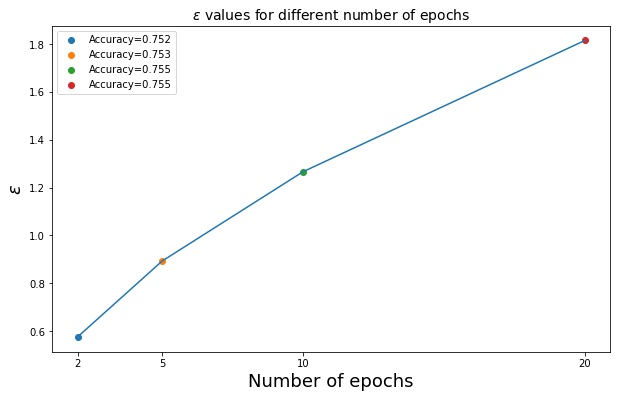

In [7]:
epsilons = []
accs = []
epochs = [2, 5, 10, 20]
for num_epochs in epochs:
    eps, _, _, acc = pipeline(
                        learning_rate, noise_multiplier, clip_bound, 
                        sample_rate, num_epochs, data
                    )
    epsilons.append(eps)
    accs.append(acc)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(epochs, epsilons)
for i in range(len(epochs)):
    plt.scatter(epochs[i], epsilons[i], label="Accuracy="+str(np.round(accs[i], 3)))
plt.xticks(epochs)
plt.xlabel("Number of epochs", fontsize=18)
plt.ylabel(r"$\epsilon$", fontsize=18)
plt.title(r"$\epsilon$ values for different number of epochs", fontsize=14)
plt.legend()
plt.show()

We notice that sometimes the classifier assigns the reverse label and so we get bad accuracy (23\%) which would be good if we considered the reverse classification label (so if we considered 0s as 1s and 1s as 0s). We will treat the "reverse" accuracies the same as the normal accuracies, and so a good accuracy will be a number that is as far away as 50\% and as close to 0\% or 100\% as possible.

We notice that increasing num_epochs=5 increases $\epsilon$ without impacting accuracy, so we leave num_epochs=2. 

Next, let's try out different learning rates.

Loss: 0.018362431378339764, Accuracy: 0.2252649595155026
Loss: 0.00872302009844182, Accuracy: 0.7513659403594234
Loss: 0.05392261389864887, Accuracy: 0.7513659403594234
Loss: 0.3725710330129682, Accuracy: 0.24850240273846355
Loss: 0.24251223869190638, Accuracy: 0.7519583964189323


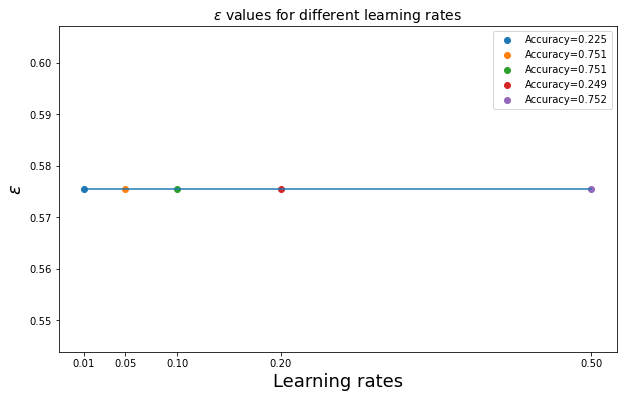

In [9]:
# Fix num_epochs for the rest of the tests
num_epochs = 2

# Testing learning rates
epsilons = []
accs = []
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5]
for lr in learning_rates:
    eps, _, _, acc = pipeline(
                        lr, noise_multiplier, clip_bound, 
                        sample_rate, num_epochs, data
                    )
    epsilons.append(eps)
    accs.append(acc)
   
# Plotting
plt.figure(figsize=(10,6))
plt.plot(learning_rates, epsilons)
for i in range(len(learning_rates)):
    plt.scatter(learning_rates[i], epsilons[i], label="Accuracy="+str(np.round(accs[i], 3)))
plt.xticks(learning_rates)
plt.xlabel("Learning rates", fontsize=18)
plt.ylabel(r"$\epsilon$", fontsize=18)
plt.title(r"$\epsilon$ values for different learning rates", fontsize=14)
plt.legend()
plt.show()

$\epsilon$ seems unaffected by the change in learning rate, while accuracy is highest for lr=0.01. We fix the learning rate and move on with testing different values for the noise multiplier.

Loss: 0.005946593981138863, Accuracy: 0.7600552958988875
Loss: 0.003776476716094362, Accuracy: 0.7801988019221908
Loss: 0.005191708307929808, Accuracy: 0.7513659403594234
Loss: 0.009613677956417451, Accuracy: 0.7574879863076822
Loss: 0.004859076047868084, Accuracy: 0.7513659403594234
Loss: 0.0030566633559852203, Accuracy: 0.7529458231847804
Loss: 0.006047974878345937, Accuracy: 0.7645974590217892
Loss: 0.009090325900011211, Accuracy: 0.7605819235073399
Epsilon values in above runs: [1333.0990114378128, 13.005959790711158, 2.2460955249463836, 0.5755486730319556, 0.18451650186347052, 0.12182426214397296, 0.10752574422942468, 0.10305258686375049]


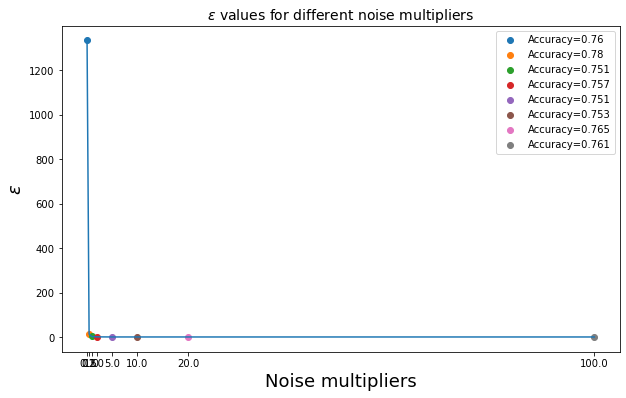

In [12]:
# Fix lr
learning_rate = 0.01

# Testing noise multipliers
epsilons = []
accs = []
noise_multipliers = [0.1, 0.5, 1, 2, 5, 10, 20, 100]
for noise_multiplier in noise_multipliers:
    eps, _, _, acc = pipeline(
                        learning_rate, noise_multiplier, clip_bound, 
                        sample_rate, num_epochs, data
                    )
    epsilons.append(eps)
    accs.append(acc)
    
print("Epsilon values in above runs:", epsilons)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(noise_multipliers, epsilons)
for i in range(len(noise_multipliers)):
    plt.scatter(noise_multipliers[i], epsilons[i], label="Accuracy="+str(np.round(accs[i], 3)))
plt.xticks(noise_multipliers)
plt.xlabel("Noise multipliers", fontsize=18)
plt.ylabel(r"$\epsilon$", fontsize=18)
plt.title(r"$\epsilon$ values for different noise multipliers", fontsize=14)
plt.legend()
plt.show()

We see that $\epsilon$ decreases as the noise multiplier increases, with noise multiplier having little effect on the accuracy. Hopefully this is not because our initial decision (num_epochs=2) has locked out better optimization regions.

Loss: 0.0210780679304615, Accuracy: 0.7609110657626226
Loss: 0.0018191029654929703, Accuracy: 0.7773681785267592
Loss: 0.0037926342479330894, Accuracy: 0.7593311829372655
Loss: 0.007105347889060289, Accuracy: 0.775524981897176
Loss: 0.005144179153768833, Accuracy: 0.7513659403594234
Loss: 0.0026815415809846805, Accuracy: 0.7555789612270424
Loss: 0.01206912860037913, Accuracy: 0.7513001119083668
Loss: 0.020638067172534313, Accuracy: 0.7513659403594234


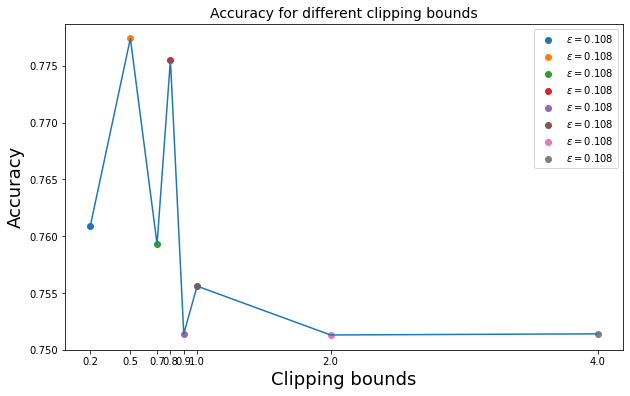

In [13]:
# Fix noise multiplier
noise_multiplier = 20.

# Testing clipping bounds
epsilons = []
accs = []
clip_bounds = [0.2, 0.5, 0.7, 0.8, 0.9, 1, 2, 4] # checking around 0.7-1 based on Marlon's work
for clip_bound in clip_bounds:
    eps, _, _, acc = pipeline(
                        learning_rate, noise_multiplier, clip_bound, 
                        sample_rate, num_epochs, data
                    )
    epsilons.append(eps)
    accs.append(np.round(acc, 4))
    
# Reverse the accuracies
for i in range(len(accs)):
    accs[i] = accs[i] if accs[i] > 0.5 else 1-accs[i]
    
# Plotting
plt.figure(figsize=(10,6))
plt.plot(clip_bounds, accs)
for i in range(len(clip_bounds)):
    plt.scatter(clip_bounds[i], accs[i], label=r"$\epsilon=$"+str(np.round(epsilons[i], 3)))
plt.xticks(clip_bounds)
plt.xlabel("Clipping bounds", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.title("Accuracy for different clipping bounds", fontsize=14)
plt.legend()
plt.show()


Clipping bound of $0.5$ seems to yield the highest accuracy, and surprisingly all of the different clipping bounds yield the same $\epsilon$ value. We proceed with the final parameter, sample rate.

Loss: 0.0017450237343226715, Accuracy: 0.7863208478704496
Loss: 0.00436336177574561, Accuracy: 0.7509709696530841
Loss: 0.0006542416747661161, Accuracy: 0.7788822329010598
Loss: 0.044446941047022084, Accuracy: 0.7513659403594234
Loss: 0.5150741045787802, Accuracy: 0.24659337765782371


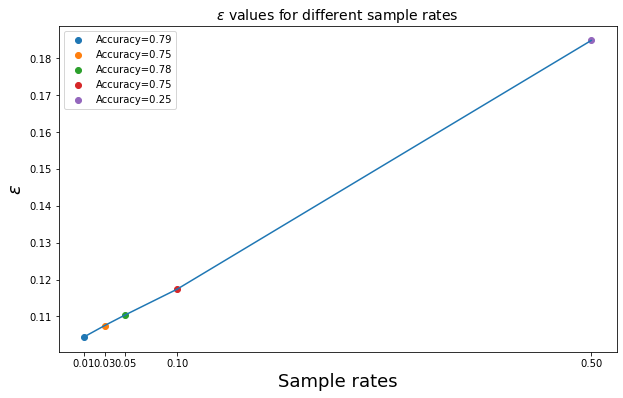

In [14]:
# Fix clipping bound
clip_bound = 0.5

# Testing sample rates
epsilons = []
accs = []
sample_rates = [0.01, 0.03, 0.05, 0.1, 0.5]
for sample_rate in sample_rates:
    eps, _, _, acc = pipeline(
                        learning_rate, noise_multiplier, clip_bound, 
                        sample_rate, num_epochs, data
                    )
    epsilons.append(eps)
    accs.append(acc)
    
# Plotting
plt.figure(figsize=(10,6))
plt.plot(sample_rates, epsilons)
for i in range(len(sample_rates)):
    plt.scatter(sample_rates[i], epsilons[i], label="Accuracy="+str(np.round(accs[i], 2)))
plt.xticks(sample_rates)
plt.xlabel("Sample rates", fontsize=18)
plt.ylabel(r"$\epsilon$", fontsize=18)
plt.title(r"$\epsilon$ values for different sample rates", fontsize=14)
plt.legend()
plt.show()

We keep sample_rate=0.01

Overall remarks based on these tests: 

i) Clipping bound of 1 seems to not be the best case universally, and sometimes setting the threshold lower can increase privacy without hurting accuracy. \
ii) We would expect that increasing noise multiplier would reduce $\epsilon$ while hurting accuracy, but in our case there seems to be a small effect on accuracy with big impact on privacy. \
iii) A smaller number of epochs seems to protect privacy more, possibly due to mitigation of an overfitting effect that can leak private information from the data. \
iv) It is very likely some of the decisions during the staircase optimization process "lock out" regions of better accuracy and lower $\epsilon$, and also probably hide other effects the change in these parameters can have. As already mentioned, this is a limited approach. \
v) Rerunning the notebook seems to produce different accuracy values, and as such would lead to different optimization decisions. I am puzzled by why this is happening, since at every step we are fixing the random seed.

In [18]:
# Example showcasing remark v)

learning_rate = 0.01
noise_multiplier = 20
clip_bound = 0.5
sample_rate = 0.01
num_epochs = 2

for _ in range(10): # repeat the same process 10 times
    eps, _, _, _ = pipeline(
        learning_rate, noise_multiplier, clip_bound, 
        sample_rate, num_epochs, data
    )
    print("Epsilon:", eps)

Loss: 0.0011865428638037634, Accuracy: 0.7766440655651372
Epsilon: 0.1044309514813036
Loss: 0.0005228503901918758, Accuracy: 0.2156540056612468
Epsilon: 0.1044309514813036
Loss: 0.004552247925889507, Accuracy: 0.7509051412020276
Epsilon: 0.1044309514813036
Loss: 0.0018915844735803555, Accuracy: 0.24962148640642487
Epsilon: 0.1044309514813036
Loss: 0.0043273794196669185, Accuracy: 0.7513659403594234
Epsilon: 0.1044309514813036
Loss: 0.004767726717139003, Accuracy: 0.7597919820946614
Epsilon: 0.1044309514813036
Loss: 0.0011409774337305498, Accuracy: 0.7800671450200777
Epsilon: 0.1044309514813036
Loss: 0.007331589997681861, Accuracy: 0.23408597195707986
Epsilon: 0.1044309514813036
Loss: 3.285929987361673e-05, Accuracy: 0.7276676979790666
Epsilon: 0.1044309514813036
Loss: 0.004642382359286543, Accuracy: 0.7801329734711342
Epsilon: 0.1044309514813036


### We get fairly good accuracy on some of the runs (78\%), but there are still runs that produce 75\% accuracy even with the optimized parameter values.

### At least our solution is strongly DP, with $\epsilon=0.1$

### ii)

Because of remark v), I had to perform many more manual searches along different parameters to come up with the best values I could find, for the best sweet-spot between privacy and accuracy. I also tried various combinations of leaving some features out of the dataset, but the choices seemed to have small impact. I report the values I found during the staircase optimization process:

In [ ]:
learning_rate = 0.01
noise_multiplier = 20
clip_bound = 0.5
sample_rate = 0.01
num_epochs = 2